importation de tout les modules necessaire aux programmes

In [46]:
import torch
import matplotlib.pyplot as plt
import gdown
import pandas as pd



telechargement du fichier de donnees


In [47]:
file_id = "1MkYWMTxsovuvAhQLlisIRgC9-RrpHRw_"
gdown.download(f"https://drive.google.com/uc?id={file_id}")

Downloading...
From: https://drive.google.com/uc?id=1MkYWMTxsovuvAhQLlisIRgC9-RrpHRw_
To: /content/data.csv
100%|██████████| 10.7k/10.7k [00:00<00:00, 8.64MB/s]


'data.csv'

lecture du fichier csv avec pandas


In [48]:
dataframe = pd.read_csv('/content/data.csv')
dataframe.describe()


,x,y
count,300.000000,300.000000
mean,0.277910,-27.653652
std,5.769276,246.521342
min,-9.913299,-878.033396
25%,-4.480942,-68.372027
50%,0.122460,23.915739
75%,5.459625,95.380362
max,9.824064,464.147759


extraction des points


In [49]:
x = torch.FloatTensor(dataframe['x'].values)
y = torch.FloatTensor(dataframe['y'].values)


affichage des donnees brut

Text(0.5, 1.0, 'donnees')

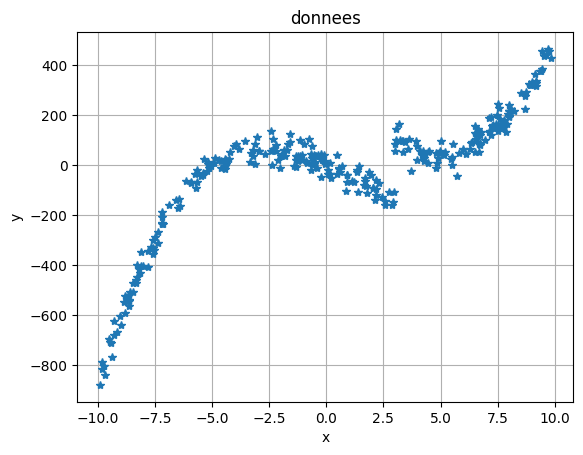

In [50]:
plt.figure()
plt.plot(x,y,'*')
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.title('donnees')



creation d'un dataset pour fournir une valeur

In [51]:
class myDataSet(torch.utils.data.Dataset):
  def __init__(self,x,y):
    self.x = x
    self.y = y
  def __len__(self):
    return len(self.x)
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

In [52]:
dataset = myDataSet(x,y)
a,b = dataset[10]
print('long', len(dataset),'a ',a,' b',b)

long 300 a  tensor(-1.0599)  b tensor(40.6843)


In [53]:
traindataset, valdataset, testdataset = torch.utils.data.random_split(dataset,[0.7, 0.15,0.15])


recuperation des ensemble de donnees pour affichage

In [54]:
xtrain = [x for x,y in iter(traindataset)]
ytrain = [y for x,y in iter(traindataset)]
xval = [x for x,y in iter(valdataset)]
yval = [y for x,y in iter(valdataset)]
xtest = [x for x,y in iter(testdataset)]
ytest = [y for x,y in iter(testdataset)]

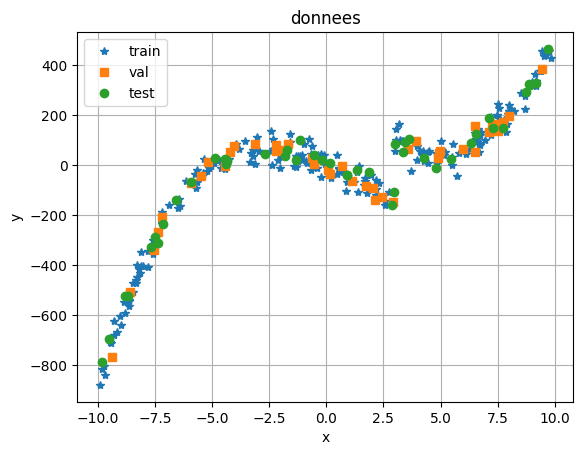

In [55]:
plt.figure()
plt.plot(xtrain,ytrain,'*')
plt.plot(xval,yval,'s')
plt.plot(xtest,ytest,'o')
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.title('donnees')
plt.legend(['train','val','test'])

creation des dataloder pour fournir les batch

In [56]:
batchSize=32#taille du lot


In [57]:
dataLoaderTrain = torch.utils.data.DataLoader(traindataset,batch_size = batchSize,shuffle= True)
dataLoaderVal = torch.utils.data.DataLoader(valdataset,batch_size = batchSize,shuffle= False)
dataLoaderTest = torch.utils.data.DataLoader(testdataset,batch_size = batchSize,shuffle= False)


In [58]:
next(iter(dataLoaderTrain))

[tensor([ 7.7678,  3.0484,  6.2984,  2.5739, -5.6427, -0.6121, -8.3300, -1.3341,
          5.1568,  3.3650,  9.4418,  2.7649, -7.5960,  4.3021, -4.9250, -9.7029,
         -0.0432, -7.8128,  4.8105,  9.8241, -2.3970, -2.3137, -8.3126, -8.6373,
          7.9710,  9.1876, -6.8661,  4.2347,  4.1222,  1.6821, -8.3006,  8.1032]),
 tensor([ 158.5077,  144.0464,   62.7032, -158.6746,  -69.1284,   77.9043,
         -459.7542,   35.9376,   41.3675,   97.5544,  457.1755, -106.9136,
         -353.4201,   43.1888,    7.8205, -838.8104,   17.3651, -342.9487,
           49.1125,  426.0833,    1.4096,  104.3363, -470.1210, -517.7902,
          203.2032,  335.6678, -157.3796,   55.3615,   57.0402,  -64.0106,
         -400.1475,  223.2919])]

verification de la dimention d'un batch

In [59]:
xbatch, ybatch = next(iter(dataLoaderTrain))
print(xbatch.size()) #une seule dimension
xbatch.unsqueeze_(1) #rajoute une dimension pour les donnees
print(xbatch.size())


torch.Size([32])
torch.Size([32, 1])


reseaux de neuronnes

In [60]:
class RegressionModel(torch.nn.Module):
  def __init__(self):
    super(RegressionModel,self).__init__()
    self.lin1 = torch.nn.Linear(1,32)
    self.lin2 = torch.nn.Linear(32,32)
    self.lin3 = torch.nn.Linear(32,1)
    self.activation = torch.nn.ReLU()

  def forward(self,x):
    y = self.lin1(x) #c'est pas y final
    y = self.activation(y)
    y = self.lin2(y)
    y = self.activation(y)
    y = self.lin3(y) # c'est y final
    return y

In [61]:
model = RegressionModel()

parametre de l'entrainement

In [62]:
epochmax = 1000
lr = 0.01
history = {'valLoss':[],'trainLoss':[]}

critere a minimiser

In [63]:
lossFcn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

boucle d'entrainement

In [64]:

for epoch in range(epochmax):
  trainLoss = 0
  model.train()
  #entrainement
  for i,(xbatch,ybatch) in enumerate(dataLoaderTrain):
    xbatch.unsqueeze_(1)
    ybatch.unsqueeze_(1)
    ypred = model(xbatch)
    loss = lossFcn(ypred,ybatch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    trainLoss += loss
  trainLoss = trainLoss/len(traindataset)
  #validation
  model.eval()
  with torch.no_grad():
    valLoss = 0
    for i,(xbatch,ybatch) in enumerate(dataLoaderVal):
      xbatch.unsqueeze_(1)
      ybatch.unsqueeze_(1)
      ypred = model(xbatch)
      loss = lossFcn(ypred,ybatch)
      valLoss += loss
    valLoss = valLoss/len(valdataset)
  print(f'{epoch + 1}, train: {trainLoss:.3f} val:{valLoss:.3f} ')
  history['trainLoss'].append(trainLoss.item())
  history['valLoss'].append(valLoss.item())



1, train: 65705.781 val:37335.391 
2, train: 64095.520 val:35760.535 
3, train: 60944.523 val:32811.438 
4, train: 54683.984 val:28433.236 
5, train: 46270.230 val:23262.504 
6, train: 35229.059 val:19755.266 
7, train: 27197.971 val:19835.473 
8, train: 21774.322 val:21531.012 
9, train: 21171.025 val:22378.693 
10, train: 21488.270 val:21509.314 
11, train: 20768.305 val:19274.678 
12, train: 20262.678 val:18621.236 
13, train: 19996.807 val:18842.619 
14, train: 19592.600 val:19011.074 
15, train: 19359.133 val:19374.459 
16, train: 19131.115 val:18938.711 
17, train: 18875.760 val:18307.502 
18, train: 18605.418 val:17844.562 
19, train: 18315.182 val:18064.402 
20, train: 18043.980 val:17743.785 
21, train: 17775.047 val:17573.705 
22, train: 17506.604 val:17106.215 
23, train: 16894.822 val:16085.720 
24, train: 16253.255 val:15270.417 
25, train: 15642.386 val:15278.771 
26, train: 15341.696 val:15010.107 
27, train: 14744.494 val:14466.756 
28, train: 14342.908 val:13816.642 
2

affichage des courbes d'entrainement pour verifier qu'il n'y ait d'overfit

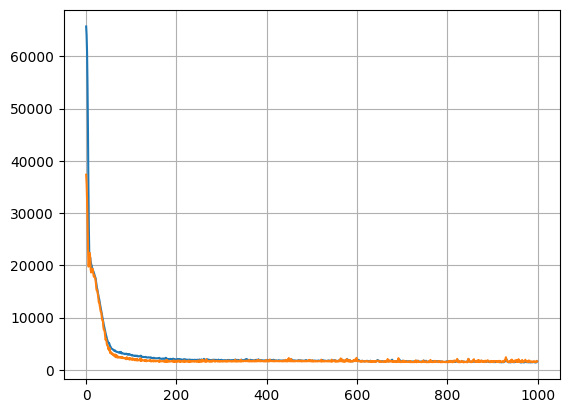

In [65]:
plt.figure()
plt.plot(history['trainLoss'])
plt.plot(history['valLoss'])
plt.grid('on')


validation du model sur l'ensemble des donnees

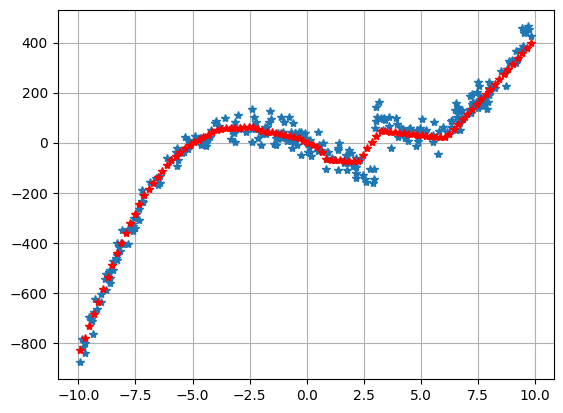

In [66]:
xx = torch.linspace(x.min(),x.max(),100)
xx.unsqueeze_(1)
model.eval()
yy = model(xx)
plt.figure()
plt.plot(x,y,'*')
plt.plot(xx.tolist(),yy.tolist(),'r*')
plt.grid('on')